In [246]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_classification
from sklearn.metrics import accuracy_score
import time

In [247]:
EPSILON = 1e-6
EPSILON_DIST = 1e-10

In [248]:
# create a dataset 
X, y = make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=.8, random_state=12)

In [249]:
# appply min max scaling and standardization
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [250]:
from sklearn.model_selection import train_test_split
X_labeled, X_unlabeled, y_labeled, y_true_unlabeled = train_test_split(X, y, random_state=12, test_size=0.5, stratify=y)

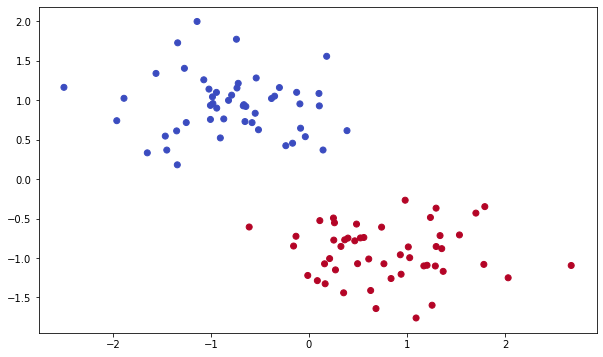

In [251]:
# plot dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm')
plt.show()

In [252]:
# calculate weights - distances
# import cosine_distances
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

# calculate distances between labeled and unlabeled points
w1 = euclidean_distances(X_labeled, X_unlabeled)

# calculate distances between unlabeled points
w2 = euclidean_distances(X_unlabeled, X_unlabeled)

# # invert distances
w1 = 1 / (w1 + EPSILON_DIST)
w2 = 1 / (w2 + EPSILON_DIST)

# normalize weights
w1=(w1-w1.min())/(w1.max()-w1.min())
w2=(w2-w2.min())/(w2.max()-w2.min())

#w1 = w1 / np.sum(w1, axis=1, keepdims=True)
#w2 = w2 / np.sum(w2, axis=1, keepdims=True)

#w1=euclidean_distances(X_labeled, X_unlabeled)/X_labeled.shape[1]
#w2=euclidean_distances(X_unlabeled, X_unlabeled)/X_unlabeled.shape[1]

In [253]:
w1

array([[0.0094031 , 0.0019097 , 0.00094022, ..., 0.00670636, 0.01069188,
        0.01039099],
       [0.001284  , 0.03692167, 0.01438474, ..., 0.00458296, 0.00215713,
        0.00363325],
       [0.00328553, 0.01032409, 0.00465628, ..., 0.00878836, 0.00545286,
        0.00810273],
       ...,
       [0.00211336, 0.02219859, 0.00772938, ..., 0.01045195, 0.00342624,
        0.00735844],
       [0.00707673, 0.00173124, 0.00085064, ..., 0.00637363, 0.00768619,
        0.00924718],
       [0.00658158, 0.00408746, 0.00216251, ..., 0.01706652, 0.01162064,
        0.04507409]])

In [254]:
y_unlabeled = np.random.rand(len(y_true_unlabeled))
y_unlabeled = np.where(y_unlabeled > 0.5, 1.0, 0.0)

## Iterative methods

In [255]:
def loss_iterative(y_labeled, y_unlabeled, w1, w2):
  term1 = 0
  term2 = 0
  for i in range(len(y_labeled)):
    for j in range(len(y_unlabeled)):
      term1 += w1[i][j] * (y_unlabeled[j] - y_labeled[i])**2
  for i in range(len(y_unlabeled)):
    for j in range(len(y_unlabeled)):
      term2 += w2[i][j] * (y_unlabeled[i] - y_unlabeled[j])**2

  return term1 + term2/ 2
  

In [256]:
# calculate gradient for y_unlabeled at j
def gradient_j_iterative(y_labeled, y_unlabeled, j, w1, w2):
  y_j = y_unlabeled[j]
  term1 = 0
  term2 = 0
  for i in range(len(y_labeled)):
    term1 += w1[i][j] * (y_j - y_labeled[i])
  for i in range(len(y_unlabeled)):
    term2 += w2[i][j] * (y_j - y_unlabeled[i])

  return 2 * term1 + term2

## Matrices methods

In [257]:
# loss function with matrices
def loss(y_unlabeled, y_labeled, w1, w2):
  term1 = np.sum((y_unlabeled.reshape(-1,1) - y_labeled.reshape(1,-1))**2 * w1.T)
  term2 = np.sum((y_unlabeled.reshape(-1,1) - y_unlabeled.reshape(1,-1))**2 * w2.T)
  return term1 + term2/2

In [258]:
# using matrices
def gradient_j(y_labeled, y_unlabeled, w1, w2, j):
  y_j = y_unlabeled[j]
  term1 = np.sum(w1[:,j] * (y_j - y_labeled))
  term2 = np.sum(w2[:,j] * (y_j - y_unlabeled))
  return 2 *term1 + term2

In [259]:
# return an array with all gradients
# TODO: invertire su tutte le funzioni
def gradient(y_unlabeled, y_labeled, w1, w2):
  term1 = np.sum((y_unlabeled.reshape(-1, 1) - y_labeled.reshape(1, -1)) * w1.T, axis=1)
  term2 = np.sum((y_unlabeled.reshape(-1, 1) - y_unlabeled.reshape(1, -1)) * w2.T, axis=1)
  return 2 * term1 + term2

In [260]:
def hessian(y_unlabeled, y_labeled, w1, w2):
  term1 = 2*np.sum(w1, axis=0)
  term2 = np.sum(w2, axis=0)
  diag=np.diag(w2)
  return np.diag(term1 + term2-diag)

In [261]:
hess=hessian(y_unlabeled, y_labeled, w1, w2)

In [262]:
eigen_val=np.linalg.eigvals(hess)
L=np.max(eigen_val)
L

4.923973749412476

In [263]:
import scipy.linalg
def estimate_lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]

In [264]:
L=estimate_lipschitz_constant(hess)
Li = np.array([hess[i][i] for i in range(len(hess))], dtype='float64')
1/L, L, Li.shape

(0.20308800389508963, 4.923973749412476, (50,))

In [265]:
def get_L(hessian):
    return np.linalg.eig(hessian).max()

In [266]:
def hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled):
    mat = np.copy(-w_unlabeled_unlabeled)
    for i in range(len(y_true_unlabeled)):
        if i % (len(y_unlabeled)) == 0 :
            print(f"{int(i/len(y_unlabeled)*100):02}% ... ", end="")
        mat[i][i] = 2 * np.sum(w_labeled_unlabeled[:,i]) + np.sum(w_unlabeled_unlabeled[:,i]) - w_unlabeled_unlabeled[i][i]
    print()
    return mat

In [267]:
def hessian_matrix2(w_unlabeled_unlabeled, w_labeled_unlabeled):
    n = len(w_unlabeled_unlabeled)
    diag = 2 * np.sum(w_labeled_unlabeled, axis=0) + np.sum(w_unlabeled_unlabeled, axis=0) - np.diag(w_unlabeled_unlabeled)
    mat = np.copy(-w_unlabeled_unlabeled)
    np.fill_diagonal(mat, diag)
    return mat

In [268]:
hessian_matrix2(w2, w1).shape

(50, 50)

In [269]:
hessian_matrix(w2, w1).diagonal()[:5]

00% ... 


array([0.42300737, 1.65260293, 0.78258704, 1.65030494, 0.54730257])

### Useful functions

In [270]:
def accuracy(y_unlabeled, y_true_unlabeled):
  y_pred = np.where(y_unlabeled > 0.5, 1.0, 0.0)
  return accuracy_score(y_pred, y_true_unlabeled)

In [271]:
def plot_graph(X_labeled, X_unlabeled, y_labeled, y_unlabeled):
  plt.figure(figsize=(10, 6))
  plt.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=y_unlabeled, cmap='coolwarm', marker='x')
  plt.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, cmap='coolwarm')
  plt.show()

In [272]:
def plot_loss_accuracy_graph(losses, accuracies, X_labeled, X_unlabeled, y_labeled, y_unlabeled):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
  ax1.set_title('Loss')
  ax1.plot(losses)
  ax2.set_title('Accuracy')
  ax2.plot(accuracies)
  ax3.set_title('Labeled/Unlabeled points')
  ax3.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=y_unlabeled, cmap='coolwarm', marker='x')
  ax3.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, cmap='coolwarm')
  plt.show()
  print('Loss: ', losses[-1])
  print('Accuracy: ', accuracies[-1])

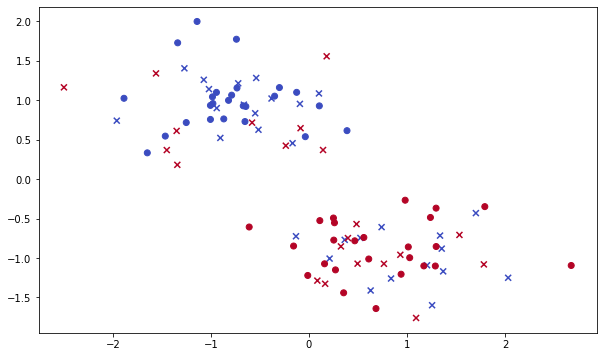

In [273]:
plot_graph(X_labeled, X_unlabeled, y_labeled, y_unlabeled)

# Calculating the learning rate

## Exact Line Search

In [274]:
from scipy.optimize import line_search

#def search_direction(alpha, direction):
    #y_unlabeled_new = y_unlabeled - alpha * direction
    #return loss(y_unlabeled_new)

# Definizione della direzione di ricerca
#direction = np.random.rand(len(y_unlabeled))

# Esecuzione della ricerca della linea esatta
#alpha = line_search(loss, gradient, y_unlabeled, direction, args=[y_labeled, w1, w2])[0]

# Stampa del valore della lunghezza del passo che minimizza la funzione obiettivo
#print(alpha)

In [275]:
#direction=-gradient(y_unlabeled, y_labeled, w1, w2)/np.linalg.norm(gradient(y_unlabeled, y_labeled, w1, w2))
#direction.shape

In [276]:
def exact_line_search(y_unlabeled, y_labeled, w1, w2, direction, max_iter=100, tol=1e-4):

    def obj_fn(alpha):
        y_j = y_unlabeled + alpha * direction
        term1 = np.sum((y_j.reshape(-1,1) - y_labeled.reshape(1,-1))**2 * w1.T)
        term2 = np.sum((y_j.reshape(-1,1) - y_unlabeled.reshape(1,-1))**2 * w2.T)
        return term1 + term2/2

    # Bracketing phase
    alpha = 1.0
    f0 = obj_fn(0.0)
    f1 = obj_fn(alpha)
    while f1 < f0:
        print(1898)
        alpha *= 2
        f0 = f1
        f1 = obj_fn(alpha)
        if alpha > 1e10:
            raise ValueError('Line search failed: alpha too large')

    # Bisection phase
    a = 0.0
    b = alpha
    fa = f0
    fb = f1
    for i in range(max_iter):
        alpha = (b - a) / 2.0
        print(alpha)
        fc = obj_fn(alpha)
        if fc < fa:
            b = alpha
            fb = fc
        else:
            a = alpha
            fa = fc
        if (b - a) < tol:
            break

    return alpha


In [277]:
def armijo_line_search(y_unlabeled, y_labeled, w1,w2, direction, c1=1e-4):
    alpha = 1.0
    rho = 0.4
    c = loss(y_unlabeled, y_labeled, w1, w2)
    gk = gradient(y_unlabeled, y_labeled, w1, w2)
    while loss(y_unlabeled+alpha*direction, y_labeled, w1, w2) > c + c1 * alpha * np.dot(gk, direction):
        alpha *= rho
    return alpha


In [278]:
direction= -gradient(y_unlabeled, y_labeled, w1, w2)

In [279]:
armijo_line_search(y_unlabeled, y_labeled, w1, w2, direction)

1.0

## Armijo Rule

In [280]:
def armijo_rule(f, grad_f, x, direction, gamma=0.1, rho=0.5, max_iter=100, *args, **kwargs):
    """
    Implements the Armijo rule for finding the optimal step size alpha that satisfies the sufficient decrease condition
    f(x + alpha*p) <= f(x) + c*alpha*grad_f(x)^T*p, where c and rho are constants.
    
    Parameters:
        f (callable): A function that takes a vector x and returns a scalar value.
        grad_f (callable): A function that takes a vector x and returns the gradient of f at x.
        x (ndarray): A numpy array representing the current value of x.
        direction (ndarray): A numpy array representing the direction of the search.
        gamma (float, optional): A constant value used to control the rate of decrease of the step size.
        rho (float, optional): A constant value used to control the rate of reduction of the step size when the condition is not satisfied.
        max_iter (int, optional): The maximum number of iterations allowed.
        
    Returns:
        alpha (float): The optimal step size that satisfies the sufficient decrease condition.
    """
    alpha = 1.0
    for i in range(max_iter):
        # Evaluate the function and its gradient at x + alpha*p 
        x_new = x + alpha * direction
        f_new = f(x_new, *args, **kwargs)
        
        # Compute the right-hand side of the sufficient decrease condition
        condition = f(x, *args, **kwargs) + gamma * alpha * np.dot(grad_f(x, *args, **kwargs), direction)

        # Check the Armijo condition
        if f_new <= condition:
            break
        
        # Reduce the step size using the reduction factor rho
        alpha *= rho
        
    return alpha

direction = np.random.rand(len(y_unlabeled))
armijo_rule(loss, gradient, y_unlabeled, direction, y_labeled=y_labeled, w1=w1, w2=w2)

0.25

# Optimization Methods

## Gradient Descent

In [281]:
# apply gradient descent
def gradient_descent(y_labeled, y_unlabeled, y_true_unlabeled, w1, w2, alpha, max_iter):
  losses = []
  accuracies = []
  for _ in range(max_iter):
    grads = gradient(y_unlabeled, y_labeled, w1, w2)
    #alpha = armijo_rule(loss, gradient, y_unlabeled, -grads, y_labeled=y_labeled, w1=w1, w2=w2)
    #print(alpha)
    if EPSILON >= np.linalg.norm(grads):
      break
    y_unlabeled = y_unlabeled - 1/L * grads
    losses.append(loss(y_unlabeled, y_labeled, w1, w2))
    accuracies.append(accuracy(y_unlabeled, y_true_unlabeled))
    time_gd.append(time.time() * 1000 - start_time*1000)
  return y_unlabeled, losses, accuracies

In [282]:
alpha=1/L
alpha

0.20308800389508963

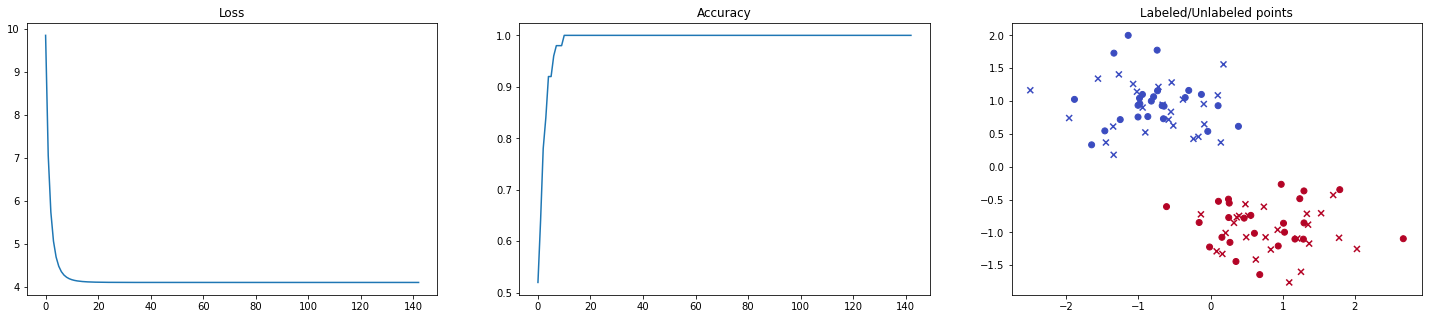

Loss:  4.11045115097283
Accuracy:  1.0
CPU time: 0.253 seconds


In [283]:
# initialize random values for y_unlabeled with values between -1 and 1
y_unlabeled_gd = y_unlabeled.copy()
time_gd=[]
start_time = time.time()
y_unlabeled_gd, losses_gd, accuracies_gd = gradient_descent(y_labeled, y_unlabeled_gd, y_true_unlabeled, w1, w2, L, 3000)
y_unlabeled_gd = np.where(y_unlabeled_gd > 0.5, 1.0, 0.0)
plot_loss_accuracy_graph(losses_gd, accuracies_gd, X_labeled, X_unlabeled, y_labeled, y_unlabeled_gd)
end_time = time.time()
execution_time_gd = end_time - start_time
print("CPU time: {:.3f}".format(execution_time_gd), "seconds")

Text(0.5, 0, 'Time (ms)')

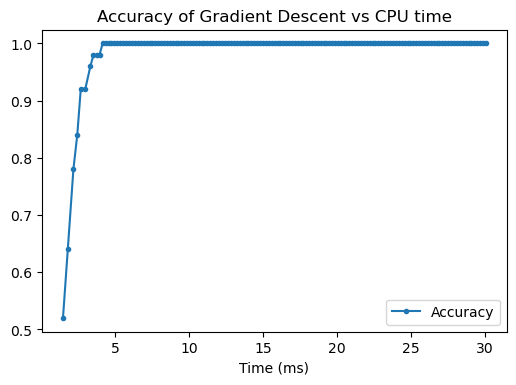

In [284]:
plt.figure(dpi=100)
plt.title("Accuracy of Gradient Descent vs CPU time")
plt.plot(time_gd, accuracies_gd, marker='.')
plt.legend(["Accuracy"])
plt.xlabel("Time (ms)")

## Randomized BCGD

In [285]:
def randomized_bcgd(y_labeled, y_unlabeled, y_true_unlabeled, w1, w2, Li, max_iter):
  losses = []
  accuracies = []
  for _ in range(max_iter):
    j = np.random.randint(len(y_unlabeled))
    grads = gradient(y_unlabeled, y_labeled, w1, w2)
    #alpha = armijo_rule(loss, gradient, y_unlabeled, -grads, rho=0.2, y_labeled=y_labeled, w1=w1, w2=w2)
    #print(alpha)
    if EPSILON >= np.linalg.norm(grads):
        break     
    y_unlabeled[j] = y_unlabeled[j] - 1/Li[j] * grads[j]
    losses.append(loss(y_unlabeled, y_labeled, w1, w2))
    accuracies.append(accuracy(y_unlabeled, y_true_unlabeled))
    time_rbcgd.append(time.time() * 1000 - start_time*1000)
  return y_unlabeled, losses, accuracies

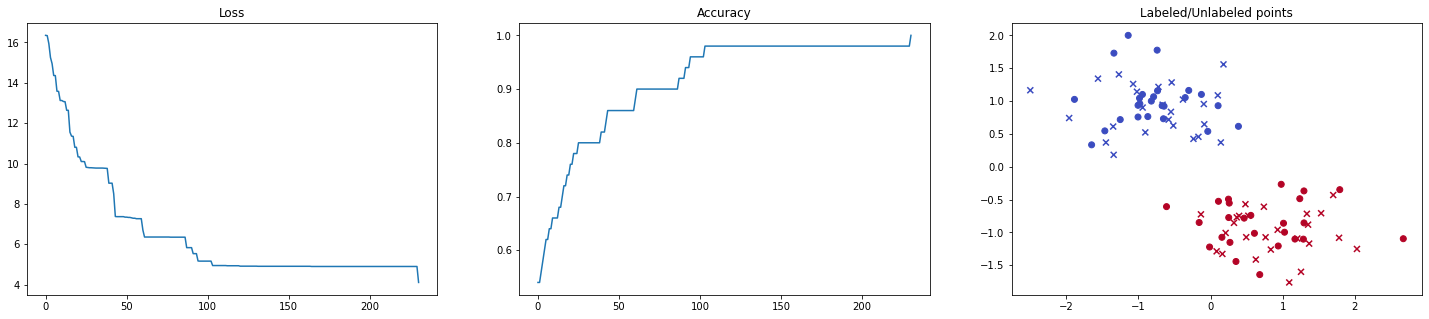

Loss:  4.11045115097181
Accuracy:  1.0
CPU time: 0.255 seconds


In [286]:
y_unlabeled_rbcgd = y_unlabeled.copy()
time_rbcgd=[]
start_time = time.time()
y_unlabeled_rbcgd, losses_rbcgd, accuracies_rbcgd = randomized_bcgd(y_labeled, y_unlabeled_rbcgd, y_true_unlabeled, w1, w2, Li, 1000)
y_unlabeled_rbcgd = np.where(y_unlabeled_rbcgd > 0.5, 1.0, 0.0)
plot_loss_accuracy_graph(losses_rbcgd, accuracies_rbcgd, X_labeled, X_unlabeled, y_labeled, y_unlabeled_rbcgd)
end_time = time.time()
execution_time_rbcgd = end_time - start_time
print("CPU time: {:.3f}".format(execution_time_rbcgd), "seconds")

Text(0.5, 0, 'Time (ms)')

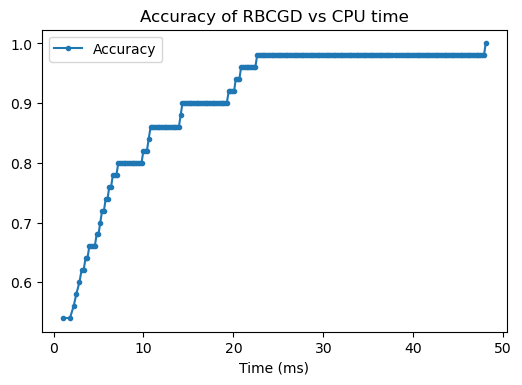

In [287]:
plt.figure(dpi=100)
plt.title("Accuracy of RBCGD vs CPU time")
plt.plot(time_rbcgd, accuracies_rbcgd, marker='.')
plt.legend(["Accuracy"])
plt.xlabel("Time (ms)")

## Gauss-Southwell BCGD 

In [288]:
def gauss_southwell_bcgd(y_labeled, y_unlabeled, y_true_unlabeled, w1, w2, Li, max_iter):
    losses = []
    accuracies = []
    for _ in range(max_iter):
      grads = gradient(y_unlabeled, y_labeled, w1, w2)
      j = np.argmax(np.abs(grads))
      if EPSILON >= np.linalg.norm(grads):
        break
      #alpha = armijo_rule(loss, gradient, y_unlabeled, -grads, rho=0.5, gamma=0.01, y_labeled=y_labeled, w1=w1, w2=w2)
      #print(alpha)
      y_unlabeled[j] = y_unlabeled[j] - 1/Li[j] * grads[j]
      losses.append(loss(y_unlabeled, y_labeled, w1, w2))
      accuracies.append(accuracy(y_unlabeled, y_true_unlabeled))
      time_gsbcgd.append(time.time() * 1000 - start_time*1000)
    return y_unlabeled, losses, accuracies

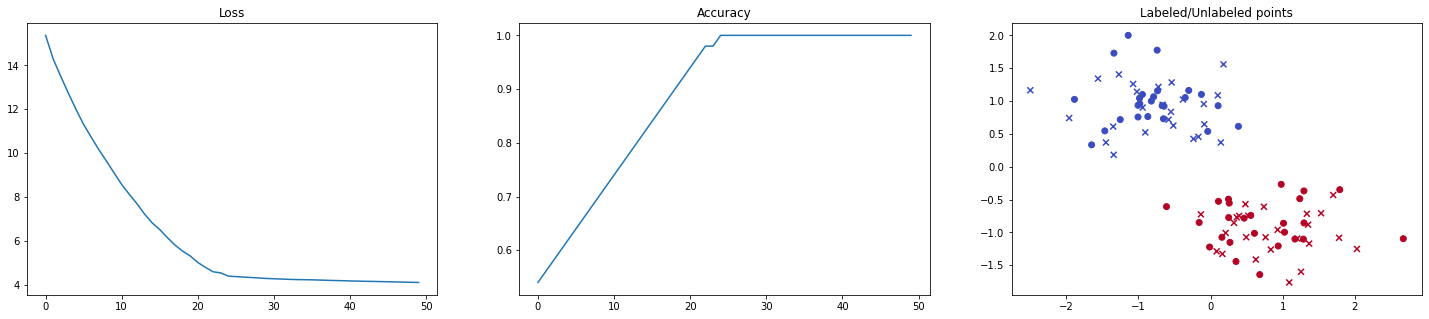

Loss:  4.11045115097181
Accuracy:  1.0
CPU time: 0.223 seconds


In [289]:
y_unlabeled_gsbcgd = y_unlabeled.copy()
time_gsbcgd=[]
start_time = time.time()
y_unlabeled_gsbcgd, losses_gsbcgd, accuracies_gsbcgd = gauss_southwell_bcgd(y_labeled, y_unlabeled_gsbcgd, y_true_unlabeled, w1, w2, Li, 4000)
y_unlabeled_gsbcgd = np.where(y_unlabeled_gsbcgd > 0.5, 1.0, 0.0)
plot_loss_accuracy_graph(losses_gsbcgd, accuracies_gsbcgd, X_labeled, X_unlabeled, y_labeled, y_unlabeled_gsbcgd)
end_time = time.time()
execution_time_gsbcgd = end_time - start_time
print("CPU time: {:.3f}".format(execution_time_gsbcgd), "seconds")

Text(0.5, 0, 'Time (ms)')

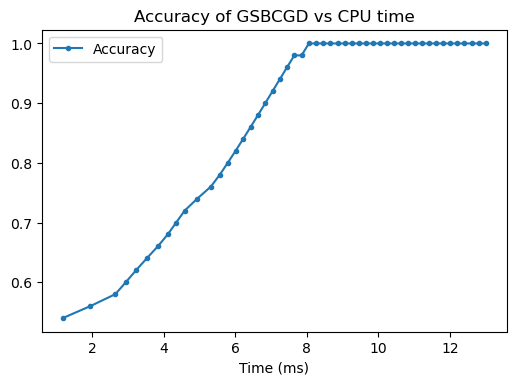

In [290]:
plt.figure(dpi=100)
plt.title("Accuracy of GSBCGD vs CPU time")
plt.plot(time_gsbcgd, accuracies_gsbcgd, marker='.')
plt.legend(["Accuracy"])
plt.xlabel("Time (ms)")

# Performances comparison

In [291]:
# table of comparison of the three algorithms
import pandas as pd
df = pd.DataFrame({'Gradient Descent': [losses_gd[-1], accuracies_gd[-1], execution_time_gd],
                    'Randomized BCGD': [losses_rbcgd[-1], accuracies_rbcgd[-1], execution_time_rbcgd],
                    'Gauss-Southwell BCGD': [losses_gsbcgd[-1], accuracies_gsbcgd[-1], execution_time_gsbcgd]},
                    index=['Loss', 'Accuracy', 'CPU time'])
df

,Gradient Descent,Randomized BCGD,Gauss-Southwell BCGD
Loss,4.110451,4.110451,4.110451
Accuracy,1.000000,1.000000,1.000000
CPU time,0.252952,0.254826,0.222765


Text(0.5, 0, 'Time (ms)')

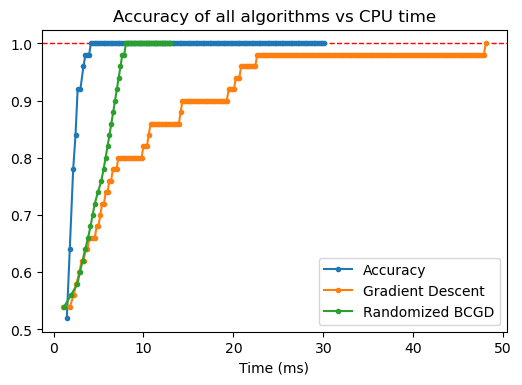

In [294]:
plt.figure(dpi=100)
plt.axhline(y=1, color='red', linestyle='dashed', lw=1, label='_nolegend_')
plt.plot(time_gd, accuracies_gd, marker='.')
plt.plot(time_rbcgd, accuracies_rbcgd, marker='.')
plt.plot(time_gsbcgd, accuracies_gsbcgd, marker='.')
plt.title("Accuracy of all algorithms vs CPU time")
plt.legend(["Accuracy", "Gradient Descent", "Randomized BCGD", "Gauss-Southwell BCGD"])
plt.xlabel("Time (ms)")


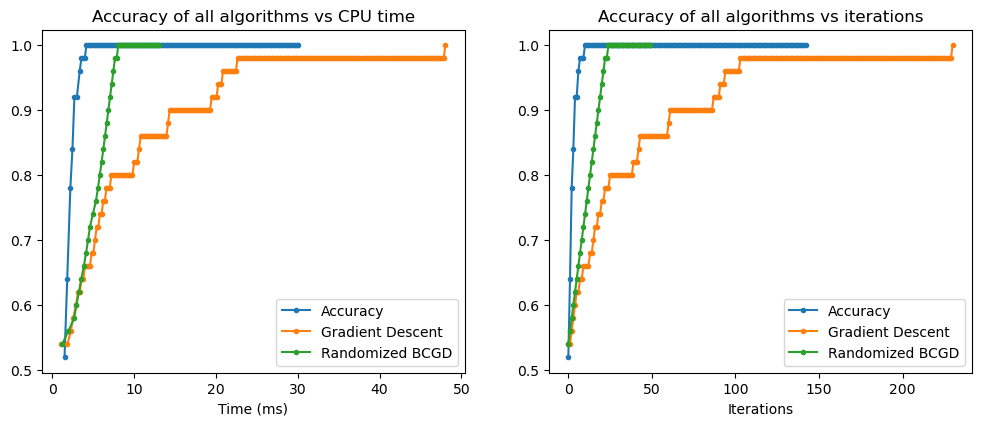

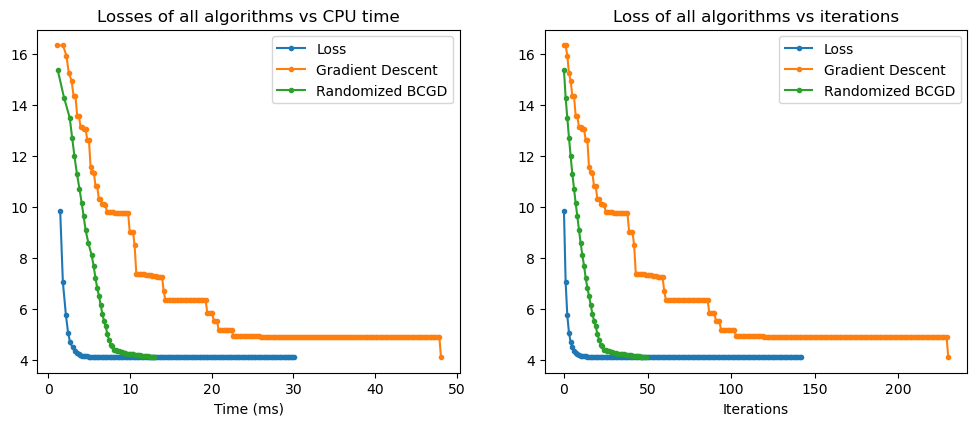

In [296]:
plt.figure(figsize=(12, 10), dpi=100)

# plot accuracy and loss of all algorithms
# accuracy vs CPU time
plt.subplot(221)
plt.plot(time_gd, accuracies_gd, marker='.')
plt.plot(time_rbcgd, accuracies_rbcgd, marker='.')
plt.plot(time_gsbcgd, accuracies_gsbcgd, marker='.')
plt.title("Accuracy of all algorithms vs CPU time")
plt.legend(["Accuracy", "Gradient Descent", "Randomized BCGD", "Gauss-Southwell BCGD"])
plt.xlabel("Time (ms)")

# accuracy vs iterations
plt.subplot(222)
plt.plot(accuracies_gd, marker='.')
plt.plot(accuracies_rbcgd, marker='.')
plt.plot(accuracies_gsbcgd, marker='.')
plt.title("Accuracy of all algorithms vs iterations")
plt.legend(["Accuracy", "Gradient Descent", "Randomized BCGD", "Gauss-Southwell BCGD"])
plt.xlabel("Iterations")

plt.figure(figsize=(12, 10), dpi=100)

# loss vs CPU time
plt.subplot(223)
plt.plot(time_gd, losses_gd, marker='.')
plt.plot(time_rbcgd, losses_rbcgd, marker='.')
plt.plot(time_gsbcgd, losses_gsbcgd, marker='.')
plt.title("Losses of all algorithms vs CPU time")
plt.legend(["Loss", "Gradient Descent", "Randomized BCGD", "Gauss-Southwell BCGD"])
plt.xlabel("Time (ms)")

# loss vs iterations
plt.subplot(224)
plt.plot(losses_gd, marker='.')
plt.plot(losses_rbcgd, marker='.')
plt.plot(losses_gsbcgd, marker='.')
plt.title("Loss of all algorithms vs iterations")
plt.legend(["Loss", "Gradient Descent", "Randomized BCGD", "Gauss-Southwell BCGD"])
plt.xlabel("Iterations")

plt.show()

# Real Dataset

In [299]:
# import flower dataset
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

# remove class 2
X = X[y != 2]
y = y[y != 2]

In [314]:
# import breast cancer dataset
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

In [315]:
# apply min max scaling and standardization
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X = (X - X.mean(axis=0)) / X.std(axis=0)

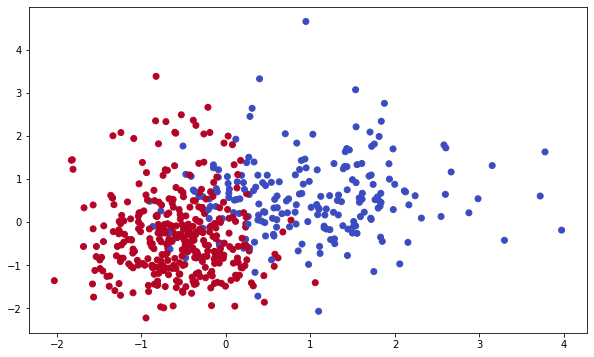

In [316]:
# vislualize dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm')
plt.show()

In [317]:
X_labeled, X_unlabeled, y_labeled, y_true_unlabeled = train_test_split(X, y, random_state=12, test_size=0.5, stratify=y)
y_unlabeled = np.random.rand(len(y_true_unlabeled))
y_unlabeled = np.where(y_unlabeled > 0.5, 1.0, 0.0)

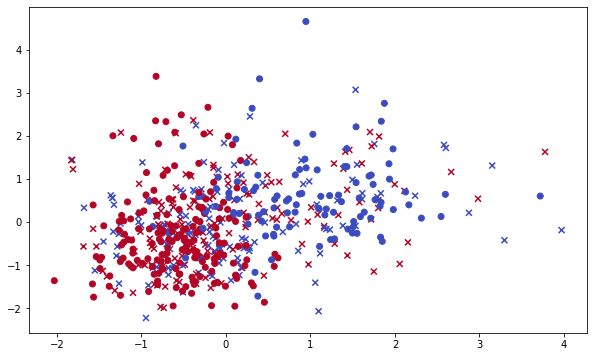

In [318]:
plot_graph(X_labeled, X_unlabeled, y_labeled, y_unlabeled)

In [319]:
w1 = euclidean_distances(X_labeled, X_unlabeled)
w2 = euclidean_distances(X_unlabeled, X_unlabeled)

w1 = 1 / (w1 + EPSILON_DIST)
w2 = 1 / (w2 + EPSILON_DIST)

#w1 = w1 / np.sum(w1, axis=1, keepdims=True)
#w2 = w2 / np.sum(w2, axis=1, keepdims=True)

# normalize weights
w1=(w1-w1.min())/(w1.max()-w1.min())
w2=(w2-w2.min())/(w2.max()-w2.min())

In [320]:
hess=hessian(y_unlabeled, y_labeled, w1, w2)
L=estimate_lipschitz_constant(hess)
Li = np.array([hess[i][i] for i in range(len(hess))], dtype='float64')
alpha=1/L
alpha


0.007502946191578366

## Using gradient descent

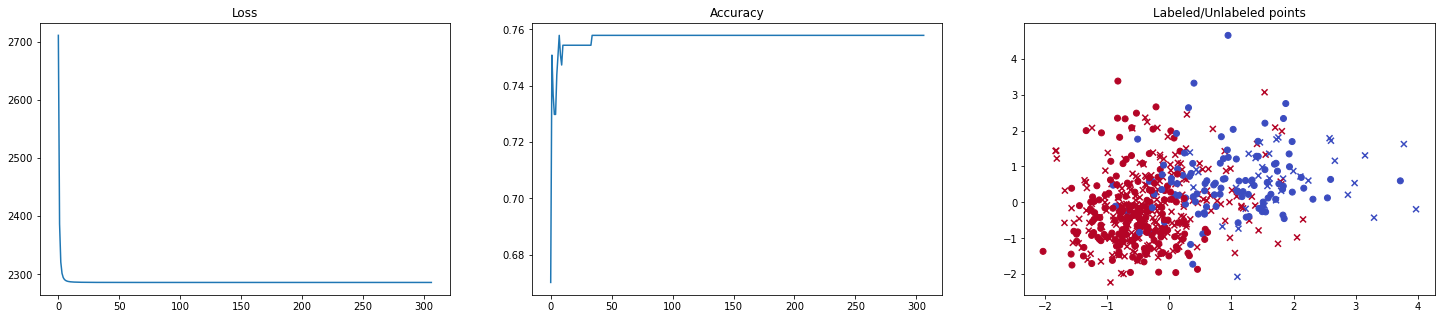

Loss:  2286.186236446024
Accuracy:  0.7578947368421053
CPU time: 0.552 seconds


In [321]:
y_unlabeled_gd = y_unlabeled.copy()
time_gd=[]
start_time = time.time()
y_unlabeled_gd, losses_gd, accuracies_gd = gradient_descent(y_labeled, y_unlabeled_gd, y_true_unlabeled, w1, w2, L, 9000)
y_unlabeled_gd = np.where(y_unlabeled_gd > 0.5, 1.0, 0.0)
plot_loss_accuracy_graph(losses_gd, accuracies_gd, X_labeled, X_unlabeled, y_labeled, y_unlabeled_gd)
end_time = time.time()
execution_time_gd = end_time - start_time
print("CPU time: {:.3f}".format(execution_time_gd), "seconds")

Text(0.5, 0, 'Time (ms)')

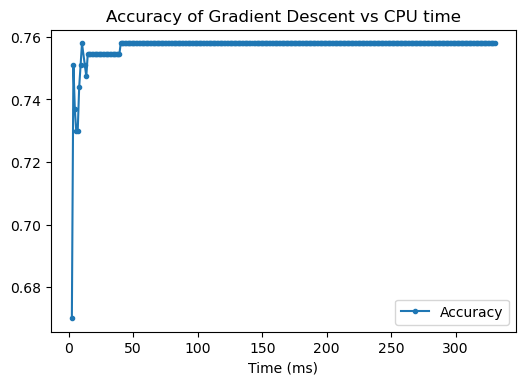

In [322]:
plt.figure(dpi=100)
plt.title("Accuracy of Gradient Descent vs CPU time")
plt.plot(time_gd, accuracies_gd, marker='.')
plt.legend(["Accuracy"])
plt.xlabel("Time (ms)")

## Using randomized BCGD

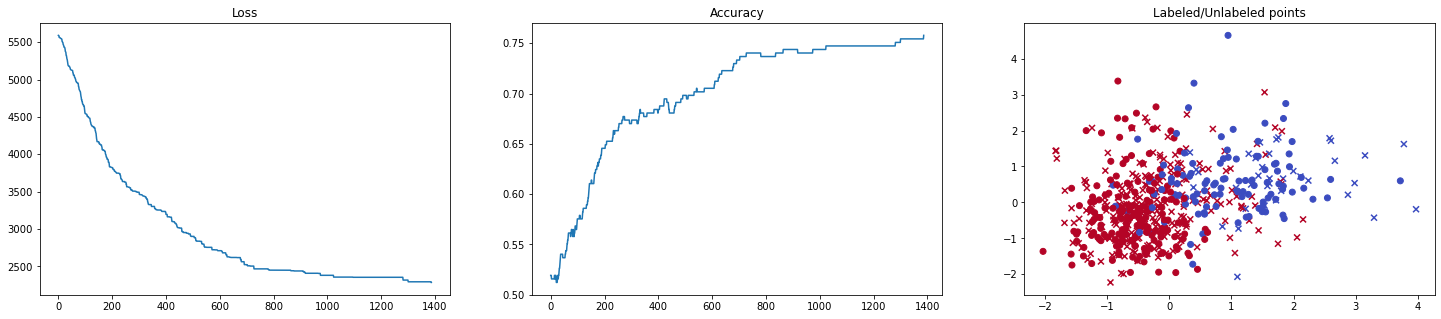

Loss:  2286.186236446023
Accuracy:  0.7578947368421053
CPU time: 1.730 seconds


In [323]:
y_unlabeled_rbcgd = y_unlabeled.copy()
time_rbcgd=[]
start_time = time.time()
y_unlabeled_rbcgd, losses_rbcgd, accuracies_rbcgd = randomized_bcgd(y_labeled, y_unlabeled_rbcgd, y_true_unlabeled, w1, w2, Li, 8000)
y_unlabeled_rbcgd = np.where(y_unlabeled_rbcgd > 0.5, 1.0, 0.0)
plot_loss_accuracy_graph(losses_rbcgd, accuracies_rbcgd, X_labeled, X_unlabeled, y_labeled, y_unlabeled_rbcgd)
end_time = time.time()
execution_time_rbcgd = end_time - start_time
print("CPU time: {:.3f}".format(execution_time_rbcgd), "seconds")

Text(0.5, 0, 'Time (ms)')

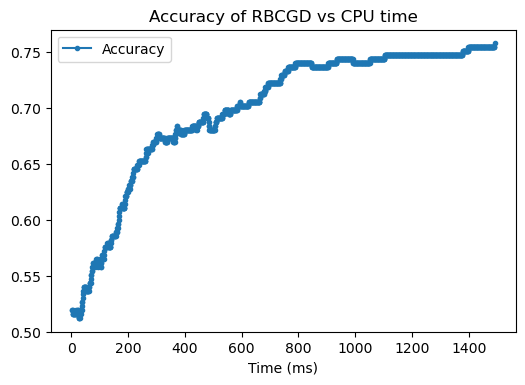

In [324]:
plt.figure(dpi=100)
plt.title("Accuracy of RBCGD vs CPU time")
plt.plot(time_rbcgd, accuracies_rbcgd, marker='.')
plt.legend(["Accuracy"])
plt.xlabel("Time (ms)")

## Using Gauss-Southwell BCGD

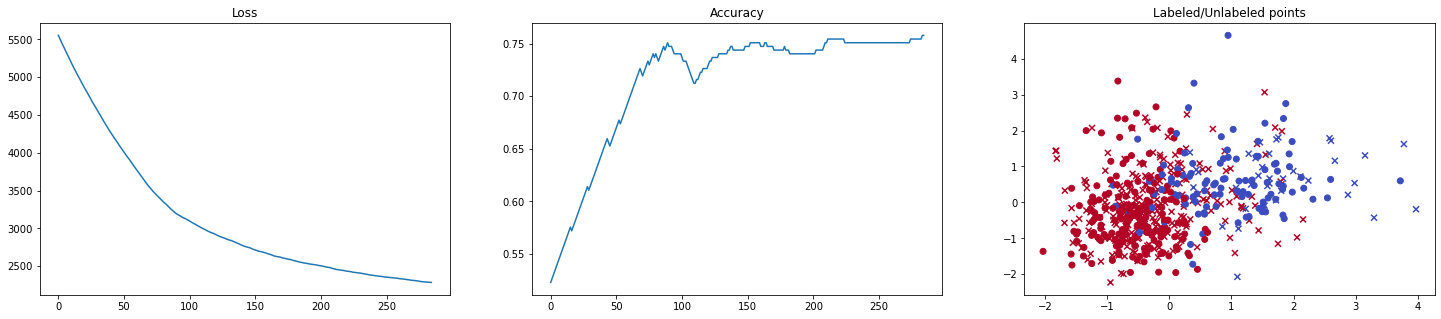

Loss:  2286.1862364460235
Accuracy:  0.7578947368421053
CPU time: 0.525 seconds


In [325]:
y_unlabeled_gsbcgd = y_unlabeled.copy()
time_gsbcgd=[]
start_time = time.time()
y_unlabeled_gsbcgd, losses_gsbcgd, accuracies_gsbcgd = gauss_southwell_bcgd(y_labeled, y_unlabeled_gsbcgd, y_true_unlabeled, w1, w2, Li, 5000)
y_unlabeled_gsbcgd = np.where(y_unlabeled_gsbcgd > 0.5, 1.0, 0.0)
plot_loss_accuracy_graph(losses_gsbcgd, accuracies_gsbcgd, X_labeled, X_unlabeled, y_labeled, y_unlabeled_gsbcgd)
end_time = time.time()
execution_time_gsbcgd = end_time - start_time
print("CPU time: {:.3f}".format(execution_time_gsbcgd), "seconds")

Text(0.5, 0, 'Time (ms)')

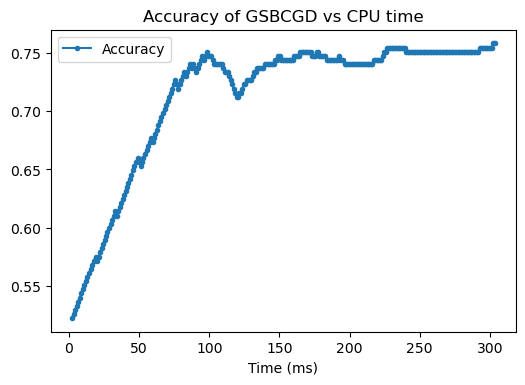

In [326]:
plt.figure(dpi=100)
plt.title("Accuracy of GSBCGD vs CPU time")
plt.plot(time_gsbcgd, accuracies_gsbcgd, marker='.')
plt.legend(["Accuracy"])
plt.xlabel("Time (ms)")

# Performances comparison

In [327]:
# table of comparison of the three algorithms
import pandas as pd
df = pd.DataFrame({'Gradient Descent': [losses_gd[-1], accuracies_gd[-1], execution_time_gd],
                    'Randomized BCGD': [losses_rbcgd[-1], accuracies_rbcgd[-1], execution_time_rbcgd],
                    'Gauss-Southwell BCGD': [losses_gsbcgd[-1], accuracies_gsbcgd[-1], execution_time_gsbcgd]},
                    index=['Loss', 'Accuracy', 'CPU time'])
df

,Gradient Descent,Randomized BCGD,Gauss-Southwell BCGD
Loss,2286.186236,2286.186236,2286.186236
Accuracy,0.757895,0.757895,0.757895
CPU time,0.551872,1.730162,0.525250


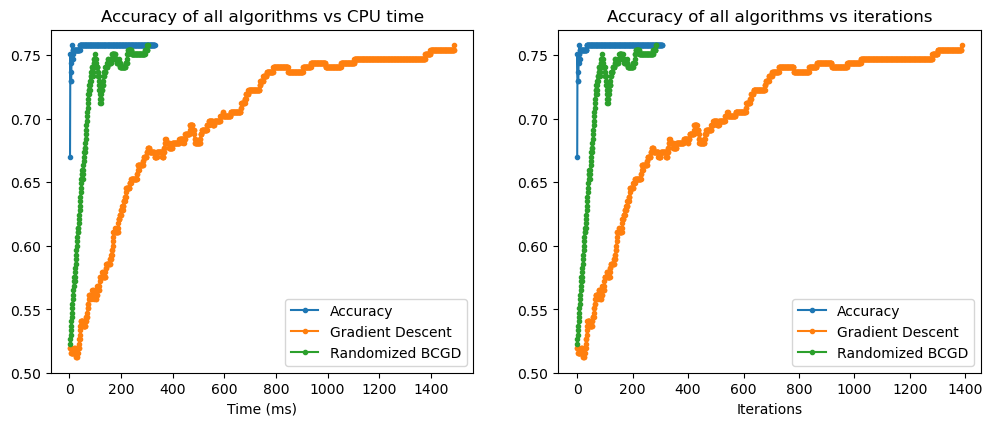

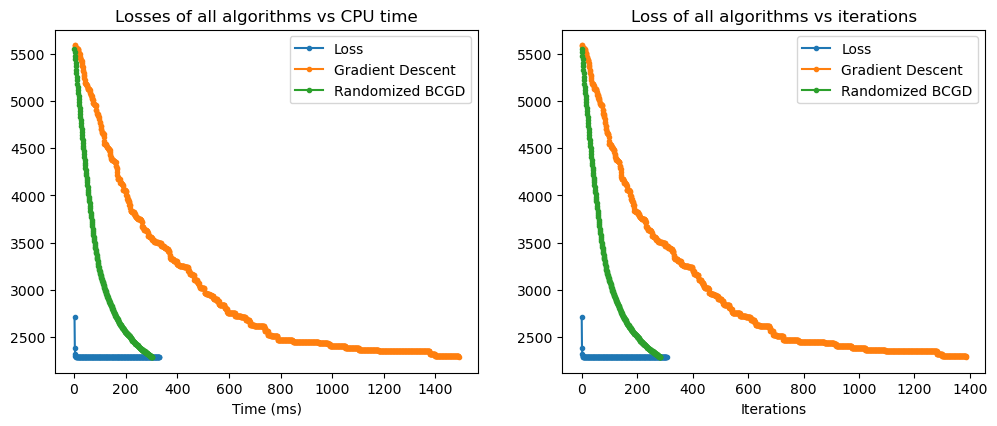

In [328]:
plt.figure(figsize=(12, 10), dpi=100)

# plot accuracy and loss of all algorithms
# accuracy vs CPU time
plt.subplot(221)
plt.plot(time_gd, accuracies_gd, marker='.')
plt.plot(time_rbcgd, accuracies_rbcgd, marker='.')
plt.plot(time_gsbcgd, accuracies_gsbcgd, marker='.')
plt.title("Accuracy of all algorithms vs CPU time")
plt.legend(["Accuracy", "Gradient Descent", "Randomized BCGD", "Gauss-Southwell BCGD"])
plt.xlabel("Time (ms)")

# accuracy vs iterations
plt.subplot(222)
plt.plot(accuracies_gd, marker='.')
plt.plot(accuracies_rbcgd, marker='.')
plt.plot(accuracies_gsbcgd, marker='.')
plt.title("Accuracy of all algorithms vs iterations")
plt.legend(["Accuracy", "Gradient Descent", "Randomized BCGD", "Gauss-Southwell BCGD"])
plt.xlabel("Iterations")

plt.figure(figsize=(12, 10), dpi=100)

# loss vs CPU time
plt.subplot(223)
plt.plot(time_gd, losses_gd, marker='.')
plt.plot(time_rbcgd, losses_rbcgd, marker='.')
plt.plot(time_gsbcgd, losses_gsbcgd, marker='.')
plt.title("Losses of all algorithms vs CPU time")
plt.legend(["Loss", "Gradient Descent", "Randomized BCGD", "Gauss-Southwell BCGD"])
plt.xlabel("Time (ms)")

# loss vs iterations
plt.subplot(224)
plt.plot(losses_gd, marker='.')
plt.plot(losses_rbcgd, marker='.')
plt.plot(losses_gsbcgd, marker='.')
plt.title("Loss of all algorithms vs iterations")
plt.legend(["Loss", "Gradient Descent", "Randomized BCGD", "Gauss-Southwell BCGD"])
plt.xlabel("Iterations")

plt.show()